# Student Thesis Supervisor Matching

The problem to solve is matching student preferences to available supervisor slots. At the same time, each supervisor should have an equal number of students and each student should get their highest preference topic. 

## Data loading

Please provide the three csv files with your own data. There are sample files in the repository.

In [1]:
import pandas as pd

df_supervisors = pd.read_csv('supervisor_details.csv', encoding='utf-8')
df_topics = pd.read_csv('thesis_topics_by_supervisor.csv', encoding='utf-8')
df_students = pd.read_csv('student_choices.csv', encoding='utf-8')

## Class generation

There are three classes to run this probabilistic simulation, a supervisor, a student and a topic.

In [2]:
class Supervisor:
    def __init__(self, id, name, titled, role, affiliation, profile, capacity):
        self.id = id
        self.name = name
        self.titled = titled
        self.role = role
        self.affiliation = affiliation
        self.profile = profile
        self.capacity = capacity
        self.topics = []
        self.cotopics = []
        self.assigned_students = []
        self.cosupervised_students = []
        self.reveal = False

    def student_load(self):
        return len(self.assigned_students) + len(self.cosupervised_students)

    def __repr__(self):
        
        return str(self.name)

class Student:
    def __init__(self, id, name):
        self.id = id
        self.name = name
        self.preferences = []
        self.topic = None
        self.attained_preference = -1

    def assign_topic(self, topic, preference):
        self.topic = topic
        self.topic.supervisor.assigned_students.append(self)
        if self.topic.cosupervisor:
            self.topic.cosupervisor.cosupervised_students.append(self)
        self.attained_preference = preference
        self.topic.final_students.append(self)
    
    def __repr__(self):
        return str(self.name)


class Topic:
    def __init__(self, id, name, supervisor, cosupervisor,capacity):
        self.id = id
        self.name = name
        self.supervisor = supervisor
        self.cosupervisor = cosupervisor
        self.interested_students = {
            1:[],
            2:[],
            3:[]
        }
        self.final_students = []
        self.capacity = capacity

    def is_available(self):
        return len(self.final_students)<self.capacity and \
               self.supervisor.capacity > self.supervisor.student_load() and \
               (not self.cosupervisor or \
               self.cosupervisor.capacity > self.cosupervisor.student_load())

    def add_student_interest(self, student, preference):
        if (preference == 1 or preference == 2 or preference == 3):
            self.interested_students[preference].append(student)
        else:
            print("Not a valid preference: " + str(preference))
    
    def __repr__(self):
        return str(self.name)


A reset function allows to recreate the baseline students, supervisors and topics without assignment links.

In [3]:
students = {}
supervisors = {}
topics = {}
def reset_all(students,supervisors,topics):
    #students = {i:Student(i, name = "Student 1 %2d" % (i)) for i in range(0,len(preferences))}
    students = {i:Student(i, name = df_students.iloc[i].loc["Name"]) for i in range(0,len(df_students))}
    
    supervisors = {df_supervisors.iloc[i,5]:Supervisor(i,
                                df_supervisors.iloc[i,1],
                                df_supervisors.iloc[i,2],
                                df_supervisors.iloc[i,3],
                                df_supervisors.iloc[i,4],
                                df_supervisors.iloc[i,5],
                                df_supervisors.iloc[i,6]) for i in range(0,len(df_supervisors))}

    topics = {df_topics.iloc[i,1]:Topic(i,
                      df_topics.iloc[i,1],
                      supervisors[df_topics.iloc[i,2]],
                      (supervisors[df_topics.iloc[i,3]] if not isinstance(df_topics.iloc[i,3], float) else None),
                      df_topics.iloc[i,5]) for i in range(0,len(df_topics))}
    
    for (i, student) in students.items():
        for j in range(5,8):
            #student.preferences.append(topics[preferences[i][j]-1])
            student.preferences.append(topics[df_students.iloc[i,j]])
            
            topics[df_students.iloc[i,j]].add_student_interest(student,j-4)

    
    for (i, topic) in topics.items():
        topic.supervisor.topics.append(topic)
        if topic.cosupervisor:
            topic.cosupervisor.cotopics.append(topic)

    return (students,supervisors,topics)

students, supervisors, topics =reset_all(students,supervisors,topics)

## Visualisation

A network visualisation of the relations between supervisors, topics and students. Topics are linked to the supervisor and students are linked to all topics in their preference list.

[]


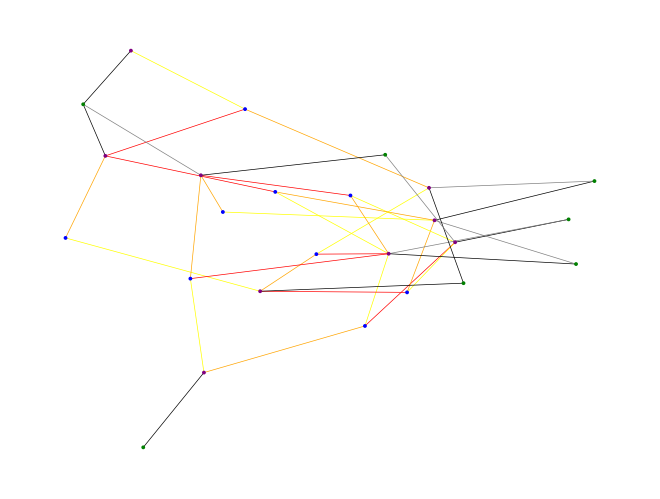

In [4]:
import networkx as nx
import matplotlib.pyplot as plt


G=nx.Graph()

start_supervisors = len(students)
start_topics = len(students) + len(supervisors)

G.add_nodes_from(students.values(),name='0student')
G.add_nodes_from(supervisors.values(),name='2supervisor')
G.add_nodes_from(topics.values(),name='1topic')

print(G.edges)

for (i,student) in students.items():
    j=1
    for (topic) in student.preferences:
        if j==1:
            G.add_edge(student,topic,weight=1,color="red", preference= j)
        elif j==2:
            G.add_edge(student,topic,weight=1,color="orange", preference= j)
        else:
            G.add_edge(student,topic,weight=1,color="yellow", preference= j)
        j = j + 1


for (i,topic) in topics.items():
    G.add_edge(topic,topic.supervisor,weight=1,color="black", object= topic)
    if topic.cosupervisor:
        G.add_edge(topic,topic.cosupervisor,weight=1,color="grey", object= topic)

color_map = []
for node in G:
    if type(node) is Student:
        color_map.append('blue')
    elif type(node) is Supervisor:
        color_map.append('green')
    else: 
        color_map.append('purple')    

pos = nx.multipartite_layout(G, subset_key="name")
#pos = nx.circular_layout(G)
pos = nx.spring_layout(G,k=0.5,pos=pos)
G_all = G
nx.draw(G_all, pos, node_color=color_map,edge_color=nx.get_edge_attributes(G_all,'color').values(),width=0.5,node_size=3)

## Naive implementation

The naive implementation tries to assign all students in a random order for n-iterations according to the rules:

- Students are offered the highest preference that is still available
- A topic is still available if the topic has capacity, the supervisor has capcity and if existing the cosupervisor has capacity

The best runs are kept to produce distribution statistics.

In [5]:
def try_assign_topic(student, topic, preference):
    if topic.is_available():
        if debug:
            print("Student " + student.name + " assigned topic " + str(topic.name))
        student.assign_topic(topic,preference)

In [6]:
import random
import sys
from collections import Counter

#TO BE SET BY USER
seed = 20240619170700
highest_accepted_fails = 9 
max_iter = 1000

#VARIABLES USED BY ALGORITHM
len_stud = len(students)
random.seed(seed)
iter_data = {}
fails = -1
min_fail = sys.maxsize
iter = 0
debug = False
while(iter<max_iter):
    if iter%1000==0:
        print(iter)
    while (fails<min_fail and iter<max_iter):
        students, supervisors, topics =reset_all(students,supervisors,topics)
        fails = 0
        
        assignment_order = [random.sample(range(0, len_stud), len_stud)]

        #Randomly select student order to assign prefered topic
        for assignment in assignment_order[0]:
            #print(assignment)
            student = students[assignment]
            pref_assignments = student.preferences#[x-1 for x in preferences[assignment]]
     
            #Is first choice available?
            pref_1 = pref_assignments[0]
            try_assign_topic(student, pref_1, 1)

            #Student didn't get first choice:
            if not student.topic:
                if debug:
                    print("Cannot assign topic " + str(pref_1.name) + " as first preference")
                #Is second choice available?
                pref_2 = pref_assignments[1]
                try_assign_topic(student, pref_2, 2)
            
            #Student didn't get first or second choice:
            if not student.topic:
                if debug:
                    print("Cannot assign topic " + str(pref_2.name) + " as second preference")
                pref_3 = pref_assignments[2]
                try_assign_topic(student, pref_3, 3)

            #Student was left without topic assignemnt:
            if not student.topic:
                if debug:
                    print("Cannot assign topic " + str(pref_3.name) + " as third preference")
                    print("Failed " + student.name)
                fails = fails + 1

        if fails<= highest_accepted_fails:
            print("Student's without supervisor: " + str(fails))
            print("min: " + str(min_fail))
            
            print(Counter([student.attained_preference for student in students.values()]))
            if min(student.attained_preference for student in students.values())<0:
                print("Critical failure OMG")

            if not fails in iter_data:
                iter_data[fails] = {}
            iter_data[fails][iter] = {'sap':sum(student.attained_preference for student in students.values())/len(students),
                               'saw':sum(supervisor.student_load()/supervisor.capacity for supervisor in supervisors.values())/len(supervisors),
                               'students':students,
                               'supervisors':supervisors,
                               'iteration':iter,
                               'topics':topics,
                               'fails':fails,
                               'minfails':min_fail,
                               'seed':seed}
            min_fail=fails
        
        if debug:
            print("completed iter " + str(iter))
        iter = iter + 1

    if fails<=min_fail:
        print("Average 1st pref. prob.: " + str(sum(1 if student.attained_preference==1 else 0 for student in students.values())/(len_stud)))
        print("Average 2nd pref. prob.: " + str(sum(1 if student.attained_preference==2 else 0 for student in students.values())/(len_stud)))
        print("Average 3nd pref. prob.: " + str(sum(1 if student.attained_preference==3 else 0 for student in students.values())/(len_stud)))
        print("Student average preference: " + str(sum(student.attained_preference if student.attained_preference >0 else 0 for student in students.values())/(len_stud-fails)))
        print("Supervisor average workload: " + str(sum(supervisor.student_load()/supervisor.capacity for supervisor in supervisors.values())/len_stud))
        print("completed iter " + str(iter))
    fails=-1

0
Student's without supervisor: 2
min: 9223372036854775807
Counter({1: 6, -1: 2, 3: 1})
Critical failure OMG
Average 1st pref. prob.: 0.6666666666666666
Average 2nd pref. prob.: 0.0
Average 3nd pref. prob.: 0.1111111111111111
Student average preference: 1.2857142857142858
Supervisor average workload: 0.5185185185185185
completed iter 1
Student's without supervisor: 2
min: 2
Counter({1: 5, -1: 2, 3: 1, 2: 1})
Critical failure OMG
Average 1st pref. prob.: 0.5555555555555556
Average 2nd pref. prob.: 0.1111111111111111
Average 3nd pref. prob.: 0.1111111111111111
Student average preference: 1.4285714285714286
Supervisor average workload: 0.4296296296296296
completed iter 2
Student's without supervisor: 1
min: 2
Counter({1: 6, 3: 2, -1: 1})
Critical failure OMG
Average 1st pref. prob.: 0.6666666666666666
Average 2nd pref. prob.: 0.0
Average 3nd pref. prob.: 0.2222222222222222
Student average preference: 1.5
Supervisor average workload: 0.6111111111111112
completed iter 3
Student's without su

### Results

Extract the best run and show some statistics.

In [7]:
import numpy as np

lowest_fail = min(iter_data.keys())
print(lowest_fail)

best_run = np.argmin([run['sap'] for key,run in iter_data[lowest_fail].items()])
print(best_run)
best_iter = list(iter_data[lowest_fail].keys())[best_run]
students = iter_data[lowest_fail][best_iter]['students']
supervisors = iter_data[lowest_fail][best_iter]['supervisors']
topics = iter_data[lowest_fail][best_iter]['topics']


print(Counter([student.attained_preference for student in students.values()]))
student_len = len(students)
print("Average 1st pref. prob.: " + str(sum(1 if student.attained_preference==1 else 0 for student in students.values())/(student_len)))
print("Average 2nd pref. prob.: " + str(sum(1 if student.attained_preference==2 else 0 for student in students.values())/(student_len)))
print("Average 3nd pref. prob.: " + str(sum(1 if student.attained_preference==3 else 0 for student in students.values())/(student_len)))
print("Student average preference: " + str(sum(student.attained_preference for student in students.values())/len(students)))
print("Supervisor average workload: " + str(sum(supervisor.student_load()/supervisor.capacity for supervisor in supervisors.values())/len(supervisors)))

0
0
Counter({1: 4, 3: 3, 2: 2})
Average 1st pref. prob.: 0.4444444444444444
Average 2nd pref. prob.: 0.2222222222222222
Average 3nd pref. prob.: 0.3333333333333333
Student average preference: 1.8888888888888888
Supervisor average workload: 0.8142857142857143


In [8]:

len(iter_data)
test=[[student.attained_preference for student in run["students"].values()] for key,run in iter_data[lowest_fail].items()]
#pp.pprint(test)
test_len = len(test)
print(test_len)
student_len = len(test[0])
print(student_len)
student_probs = {i:{1:0,2:0,3:0} for i in range(0,student_len)}
#print(student_probs)
for i in range(0,student_len):
    for j in range(0,test_len):
        if test[j][i]>0:
            student_probs[i][test[j][i]]= student_probs[i][test[j][i]]+1  
print(student_probs)
print("Average 1st pref. prob.: " + str(sum(student[1][1] for student in student_probs.items())/(test_len*student_len)))
print("Average 2nd pref. prob.: " + str(sum(student[1][2] for student in student_probs.items())/(test_len*student_len)))
print("Average 3nd pref. prob.: " + str(sum(student[1][3] for student in student_probs.items())/(test_len*student_len)))

21
9
{0: {1: 18, 2: 3, 3: 0}, 1: {1: 8, 2: 0, 3: 13}, 2: {1: 0, 2: 0, 3: 21}, 3: {1: 8, 2: 13, 3: 0}, 4: {1: 12, 2: 9, 3: 0}, 5: {1: 10, 2: 0, 3: 11}, 6: {1: 0, 2: 21, 3: 0}, 7: {1: 21, 2: 0, 3: 0}, 8: {1: 1, 2: 2, 3: 18}}
Average 1st pref. prob.: 0.4126984126984127
Average 2nd pref. prob.: 0.25396825396825395
Average 3nd pref. prob.: 0.3333333333333333


### Visual

Show the final assignment on the network.

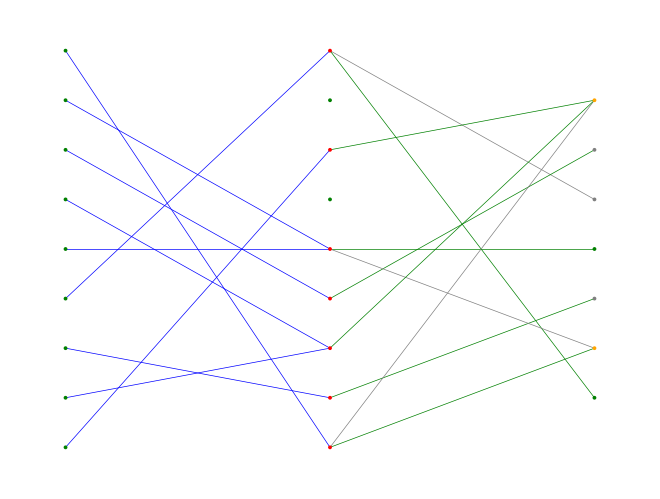

In [9]:

G=nx.Graph()

start_supervisors = len(students)
start_topics = len(students) + len(supervisors)

G.add_nodes_from(students.values(),name='0student')
G.add_nodes_from(supervisors.values(),name='2supervisor')
G.add_nodes_from(topics.values(),name='1topic')

for (i,student) in students.items():
    if student.topic:
        G.add_node(student,name="0 Student",color = "green")
        G.add_edge(student,student.topic,weight=1,color= "blue", preference= j)
    else:
        G.add_node(student,name="0 Student",color = "red")

for (i, supervisor) in supervisors.items():
    if supervisor.affiliation == "Laboratory of Geo-information Science and Remote Sensing":
        if supervisor.student_load()  / supervisor.capacity >1:
            G.add_node(supervisor,name="2 Supervisor",color= "red")
        elif supervisor.student_load()  / supervisor.capacity >0.75:
            G.add_node(supervisor,name="2 Supervisor",color= "orange")
        elif supervisor.student_load()  / supervisor.capacity >0.5:
            G.add_node(supervisor,name="2 Supervisor",color= "yellow")
        else:
            G.add_node(supervisor,name="2 Supervisor",color= "green")
    else:
        G.add_node(supervisor,name="2 Supervisor",color= "grey")
    

for (i,topic) in topics.items():
    if len(topic.final_students)  / topic.capacity >0.95:
        G.add_node(topic,name="1 Topic", color= "red")
    elif len(topic.final_students)  / topic.capacity >0.75:
        G.add_node(topic,name="1 Topic", color= "orange")
    elif len(topic.final_students)  / topic.capacity >0.5:
        G.add_node(topic,name="1 Topic", color= "yellow")
    else:
        G.add_node(topic,name="1 Topic", color= "green")
    if len(topic.final_students)>0:
        G.add_edge(topic,topic.supervisor,weight=1,color= "green", object= topic)
        if topic.cosupervisor:
            G.add_edge(topic,topic.cosupervisor,weight=1,color= "grey", object= topic)

#pos = nx.circular_layout(G)
pos = nx.multipartite_layout(G, subset_key="name")
G_naive = G
nx.draw(G_naive, pos, node_color=nx.get_node_attributes(G_naive,'color').values(),edge_color=nx.get_edge_attributes(G_naive,'color').values(),width=0.5,node_size=3)

## Optimise supervisor load

Currently unused. Visit advisors with low load and check if a student's lower ranking preference for a topic can be assigned to improve the workload of advisors.

In [10]:
for (i,supervisor) in supervisors.items():
    if supervisor.affiliation == "Laboratory of Geo-information Science and Remote Sensing":
        if supervisor.student_load()  / supervisor.capacity <= 0.75:
            print("Reassigning students optimally...")
            for topic in supervisor.topics:
                print("Supervisor " + supervisor.name + " has " + str(supervisor.student_load()) + "/" + str(supervisor.capacity) + " students.")
                print("    Main:" + topic.name + ": " + str(len(topic.final_students)) + "/" + str(topic.capacity))
                for j in range(1,4):
                    for student in topic.interested_students[j]:
                        if not student.topic is topic:
                            print("         " + str(j) + " preference for " + student.name + " | current pref used: " + str(student.attained_preference))

                if len(topic.final_students) < topic.capacity:
                    print("             Assigning second preference students ...")
                    len_pref_2 = len(topic.interested_students[2])
                    if (len_pref_2>0):
                        random_idx = 0
                        #print(len_pref_2)
                        if (len_pref_2>1):
                            random_idx = random.sample(range(0, len_pref_2), 1)[0]
                        #print(random_idx)
                        student = topic.interested_students[2][random_idx]

                        if (not student in topic.final_students):
                            #Clear student topic
                            print("             Remove topic " + student.topic.name + " for " + student.name + " ...")
                            student.topic.supervisor.assigned_students.remove(student)
                            if student.topic.cosupervisor:
                                student.topic.cosupervisor.cosupervised_students.remove(student)
                            student.topic.final_students.remove(student)
    
                            #Assign new topic
                            print("             Assign topic " + topic.name + " for " + student.name + " ...")
                            topic.supervisor.assigned_students.append(student)
                            if topic.cosupervisor:
                                topic.cosupervisor.cosupervised_students.append(student)
                            student.topic = topic
                            student.attained_preference = 2
                            topic.final_students.append(student)
                            print("             Transfer completed: " + student.topic.name + " for " + student.name )
                        else:
                            print("             Already assigned: " + student.topic.name + " for " + student.name)
                    
                
                if len(topic.final_students) < topic.capacity:
                    print("             Assigning third preference students ...")
                    len_pref_3 = len(topic.interested_students[3])
                    if (len_pref_3>0):
                        random_idx = 0
                        #print(len_pref_3)
                        if (len_pref_2>1):
                            random_idx = random.sample(range(0, len_pref_3), 1)[0]
                        #print(random_idx)
                        student = topic.interested_students[3][random_idx]

                        if (not student in topic.final_students):
                            #Clear student topic
                            print("             Remove topic " + student.topic.name + " for " + student.name + " ...")
                            student.topic.supervisor.assigned_students.remove(student)
                            if student.topic.cosupervisor:
                                student.topic.cosupervisor.cosupervised_students.remove(student)
                            student.topic.final_students.remove(student)
    
                            #Assign new topic
                            print("             Assign topic " + topic.name + " for " + student.name + " ...")
                            topic.supervisor.assigned_students.append(student)
                            if topic.cosupervisor:
                                topic.cosupervisor.cosupervised_students.append(student)
                            student.topic = topic
                            student.attained_preference = 2
                            topic.final_students.append(student)
                            print("             Transfer completed: " + student.topic.name + " for " + student.name )
                        else:
                            print("             Already assigned: " + student.topic.name + " for " + student.name)
                    
            for topic in supervisor.cotopics:
                print("    Co:" + topic.name + ": " + str(len(topic.final_students)) + "/" + str(topic.capacity))
                for j in range(1,4):
                    for student in topic.interested_students[j]:
                        if not student.topic is topic:
                            print("         " + str(j) + " preference for " + student.name + " | current pref used: " + str(student.attained_preference))

            

Reassigning students optimally...
Supervisor Supervisor 1 has 2/5 students.
    Main:Topic A: 2/2
         3 preference for Student 6 | current pref used: 1
    Co:Topic C: 0/2
         1 preference for Student 4 | current pref used: 2
         1 preference for Student 9 | current pref used: 3
         2 preference for Student 6 | current pref used: 1
         3 preference for Student 1 | current pref used: 1
         3 preference for Student 8 | current pref used: 1
Reassigning students optimally...
Supervisor Supervisor 5 has 1/2 students.
    Main:Topic E: 1/1
         2 preference for Student 2 | current pref used: 3
         2 preference for Student 8 | current pref used: 1
    Co:Topic H: 0/3
         2 preference for Student 3 | current pref used: 3
         3 preference for Student 4 | current pref used: 2


In [11]:
sap=sum(student.attained_preference for student in students.values())/len(students)
saw=sum(supervisor.student_load()/supervisor.capacity for supervisor in supervisors.values())/len(supervisors)
print("Student average preference: " + str(sap))
print("Supervisor average workload: " + str(saw))

Student average preference: 1.8888888888888888
Supervisor average workload: 0.8142857142857143


# Export

Produces csv files of the assignments and the loads on supervisors.

In [12]:
topic_assignments = pd.DataFrame(columns=["Email",
                                          "Name",
                                          "Intended start date of thesis",
                                          "Intended end date of thesis (approximate)",
                                          "choice",
                                          "Assigned topic",
                                          "supervisor",
                                          "supervisor 2",
                                         "First choice",
                                          "1 supervisor",
                                          "1 supervisor 2",
                                          "Second Choice",
                                          "2 supervisor",
                                          "2 supervisor 2",
                                          "Third Choice",
                                          "3 supervisor",
                                          "3 supervisor 2"])

for student in students.values():
    entry = pd.DataFrame.from_dict({
         "Email": [""],
         "Name": [student.name],
         "Intended start date of thesis": [""],
         "Intended end date of thesis (approximate)": [""],
         "choice": [student.attained_preference],
         "Assigned topic": [student.topic.name if student.topic else "NO TOPIC ASSIGNED"],
         "supervisor": [student.topic.supervisor.name if student.topic else ""],
         "supervisor 2": [student.topic.cosupervisor.name if student.topic and student.topic.cosupervisor else ""],
         "First choice": [student.preferences[0].name if student.preferences[0] else "NO TOPIC ASSIGNED"],
         "1 supervisor": [student.preferences[0].supervisor.name if student.preferences[0] else "NO TOPIC ASSIGNED"],
         "1 supervisor 2": [student.preferences[0].cosupervisor.name if student.preferences[0].cosupervisor else ""],
         "Second Choice": [student.preferences[1].name if student.preferences[1] else "NO TOPIC ASSIGNED"],
         "2 supervisor": [student.preferences[1].supervisor.name if student.preferences[1] else "NO TOPIC ASSIGNED"],
         "2 supervisor 2": [student.preferences[1].cosupervisor.name if student.preferences[1].cosupervisor else ""],
         "Third Choice": [student.preferences[2].name if student.preferences[2] else "NO TOPIC ASSIGNED"],
         "3 supervisor": [student.preferences[2].supervisor.name if student.preferences[2] else "NO TOPIC ASSIGNED"],
         "3 supervisor 2": [student.preferences[2].cosupervisor.name if student.preferences[2].cosupervisor else ""]
    })
    
    topic_assignments = pd.concat([topic_assignments, entry], ignore_index=True)

topic_assignments.to_csv("topic_assignments.csv", encoding='utf-8', index=False)

In [13]:
supervisor_load = pd.DataFrame(columns=["Name",
                                        "Load",
                                        "Direct",
                                        "Indirect",
                                        "Capacity"])

for supervisor in supervisors.values():
    entry = pd.DataFrame.from_dict({
         "Name": [supervisor.name],
         "Load": [supervisor.student_load()],
         "Direct": [len(supervisor.assigned_students)],
         "Indirect": [len(supervisor.cosupervised_students)],
         "Capacity": [supervisor.capacity]
    })
    
    supervisor_load = pd.concat([supervisor_load, entry], ignore_index=True)

supervisor_load.to_csv("supervisor_load.csv", encoding='utf-8', index=False)